In [1]:
from qcportal import PortalClient
from qcelemental.models.results import WavefunctionProtocolEnum
from openff.qcsubmit.results import OptimizationResultCollection,BasicResultCollection
from openff.qcsubmit.datasets import BasicDataset
from openff.qcsubmit.results.filters import ConnectivityFilter, ConformerRMSDFilter
from openff.qcsubmit.factories import BasicDatasetFactory
from openff.qcsubmit.common_structures import Metadata, QCSpec
import numpy as np
from openff.toolkit import Molecule

# Download/process QCA Dataset

In [2]:
client = PortalClient("https://api.qcarchive.molssi.org:443/")

In [3]:
esp_50k_ds = BasicResultCollection.from_server(
    client=client,
    datasets=["OpenFF ESP Fragment Conformers v1.0"],
    spec_name="spec_1"
)

In [4]:
br_ds = OptimizationResultCollection.from_server(
    client=client,
    datasets=["OpenFF multi-Br ESP Fragment Conformers v1.0"],
    spec_name="HF/6-31G*"
)

Not filtering the other DS because it's too big. I tested filtering after sub-sampling, and it only eliminated a few records. Hopefully not an issue for just benchmarking the timing.

In [6]:
filtered_br_ds = br_ds.filter(
    ConnectivityFilter(),
    ConformerRMSDFilter(rmsd_tolerance=0.05)
)

In [8]:
print(esp_50k_ds.n_results,esp_50k_ds.n_molecules)
print(br_ds.n_results,br_ds.n_molecules)
print(filtered_br_ds.n_results,filtered_br_ds.n_molecules)

65116 49526
677 611
644 610


In [100]:
esp_50k_ds.n_results/(esp_50k_ds.n_results + filtered_br_ds.n_results)

0.9902068126520681

In [101]:
filtered_br_ds.n_results/(esp_50k_ds.n_results + filtered_br_ds.n_results)

0.009793187347931873

Want ~1000 molecules for the benchmark dataset. Approximately 99% (990 molecules) should be from the 50k ESP, and 1% (10 molecules) from Multi-Br. 

## Explore ds

### ESP 50k

In [10]:
all_mols = [Molecule.from_mapped_smiles(mol.cmiles,allow_undefined_stereo=True) for mol in esp_50k_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [11]:
all_mols_br_filtered = [Molecule.from_mapped_smiles(mol.cmiles,allow_undefined_stereo=True) for mol in filtered_br_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [12]:
masses_50k = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in all_mols
])
print("ESP 50k MW (min, mean, max):", masses_50k.min(), masses_50k.mean(), masses_50k.max())

masses_multibr = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in all_mols_br_filtered
])
print("Br Filt MW (min, mean, max):", masses_multibr.min(), masses_multibr.mean(), masses_multibr.max())

ESP 50k MW (min, mean, max): 40.06412800000001 148.8372769343165 313.374798
Br Filt MW (min, mean, max): 201.84508399999999 294.10740457096273 466.5868909999999


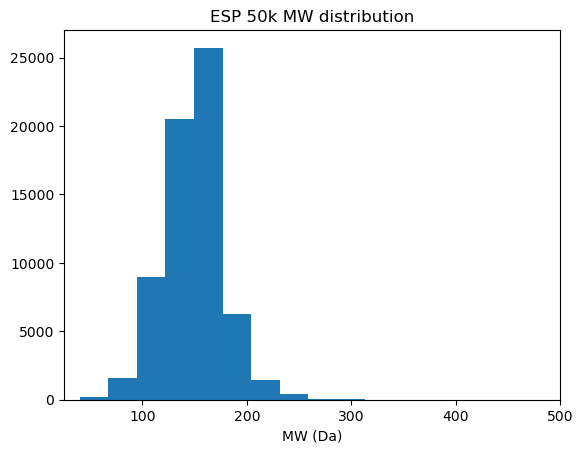

In [21]:
from matplotlib import pyplot as plt
plt.figure()
plt.hist(masses_50k)
plt.xlim(25, 500)
plt.title('ESP 50k MW distribution')
plt.xlabel('MW (Da)')
plt.show()

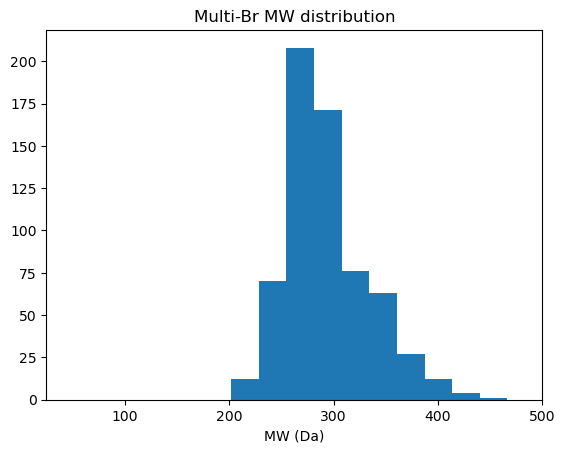

In [22]:
plt.figure()
plt.hist(masses_multibr)
plt.xlim(25, 500)
plt.title('Multi-Br MW distribution')
plt.xlabel('MW (Da)')
plt.show()

In [52]:
esp_all_atoms = [atom.symbol
    for mol in all_mols
    for atom in mol.atoms]

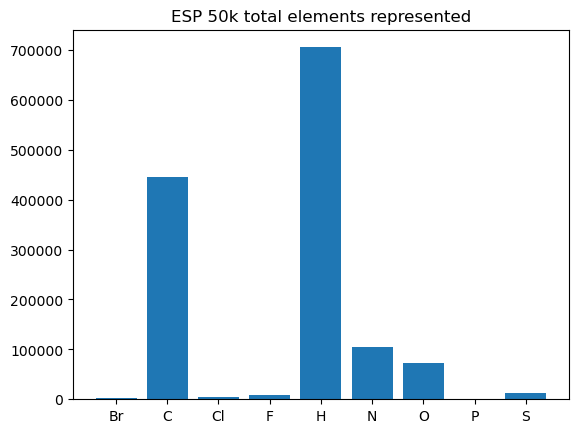

In [147]:
esp_all_atoms_labels, esp_all_atoms_counts = np.unique(esp_all_atoms,return_counts=True)
plt.plot()
plt.bar(esp_all_atoms_labels,esp_all_atoms_counts)
plt.title('ESP 50k total elements represented')
plt.show()

In [54]:
br_all_atoms = [atom.symbol
    for mol in all_mols_br_filtered
    for atom in mol.atoms]

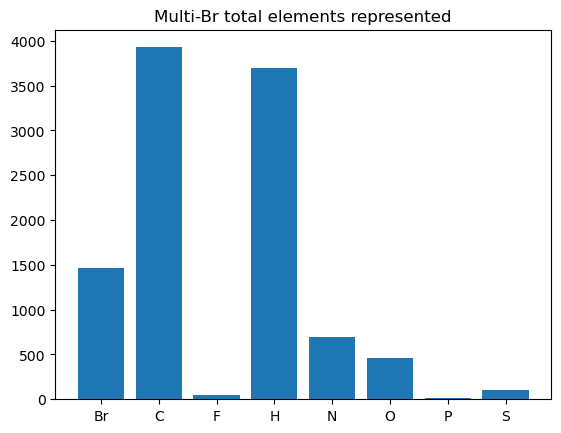

In [145]:
br_all_atoms_labels,br_all_atoms_counts = np.unique(br_all_atoms,return_counts=True)


plt.plot()
plt.bar(br_all_atoms_labels,br_all_atoms_counts)
plt.title('Multi-Br total elements represented')
plt.show()

In [26]:
atoms = []
for mol in all_mols:
    atoms.extend(np.unique([atom.symbol for atom in mol.atoms]))

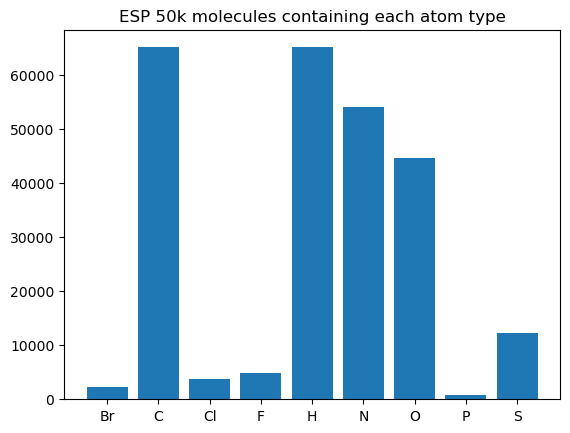

In [143]:
atoms_labels,atoms_counts = np.unique(atoms,return_counts=True)


plt.plot()
plt.bar(atoms_labels,atoms_counts)
plt.title("ESP 50k molecules containing each atom type")
plt.show()

In [28]:
atoms_br = []
for mol in all_mols_br_filtered:
    atoms_br.extend(np.unique([atom.symbol for atom in mol.atoms]))

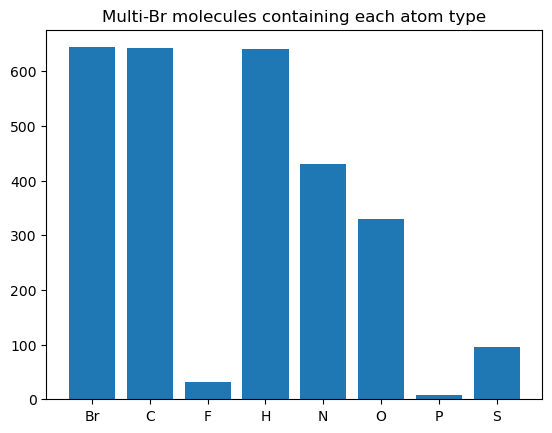

In [142]:
atoms_br_labels,atoms_br_counts = np.unique(atoms_br,return_counts=True)

plt.plot()
plt.bar(atoms_br_labels,atoms_br_counts)
plt.title("Multi-Br molecules containing each atom type")
plt.show()

# Play with deepchem DS

In [30]:
import deepchem as dc

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


This module requires PyTorch to be installed.


In [31]:
smiles_esp = [mol.to_smiles() for mol in all_mols]

In [32]:
qcaids_esp = [record.record_id for record in  esp_50k_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [33]:
dataset_esp50k=dc.data.NumpyDataset(smiles_esp,qcaids_esp)

In [34]:
smiles_br = [mol.to_smiles() for mol in all_mols_br_filtered]
qcaids_br = [record.record_id for record in filtered_br_ds.entries["https://api.qcarchive.molssi.org:443/"]]
dataset_br = dc.data.NumpyDataset(smiles_br, qcaids_br)

## Random splitter

In [88]:
seed = 1234

In [36]:
random_splitter = dc.splits.RandomSplitter()

### ESP 50k dataset

In [121]:
ft_esp=.9848
x_esp,y_esp = random_splitter.train_test_split(dataset = dataset_esp50k, frac_train = ft_esp,seed=seed)#, frac_test = 0.5)
print(x_esp.X.shape[0],y_esp.X.shape[0])

64126 990


In [122]:
# from openff.toolkit import Molecule
masses_random_x_esp = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in x_esp.X
])
print("MW (min, mean, max):", masses_random_x_esp.min(), masses_random_x_esp.mean(), masses_random_x_esp.max())

MW (min, mean, max): 40.06412800000001 148.84321606698765 313.374798


In [123]:
# from openff.toolkit import Molecule
masses_random_y_esp = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in y_esp.X
])
print("MW (min, mean, max):", masses_random_y_esp.min(), masses_random_y_esp.mean(), masses_random_y_esp.max())

MW (min, mean, max): 58.10263600000002 148.45257711444447 265.930772


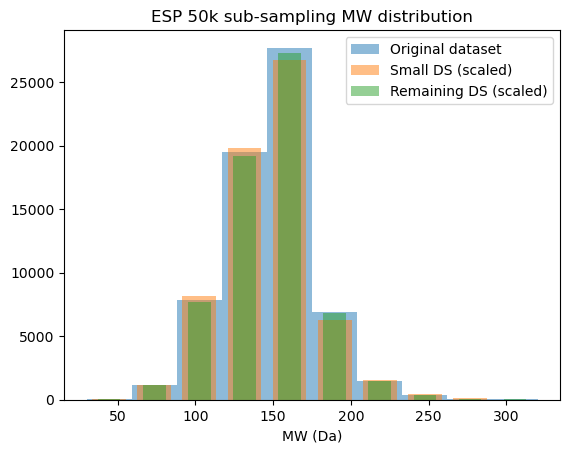

In [124]:
plt.figure()
plt.hist(masses_50k,alpha = 0.5,range=(30,320),label='Original dataset')
plt.hist(np.tile(masses_random_y_esp,int(1/(1-ft_esp))),alpha = 0.5,range=(30,320),rwidth=0.75,label='Small DS (scaled)')
plt.hist(np.tile(masses_random_x_esp,int(1/ft_esp)),alpha = 0.5,range=(30,320),rwidth=0.5,label='Remaining DS (scaled)')
plt.title('ESP 50k sub-sampling MW distribution')
plt.xlabel("MW (Da)")
plt.legend()
plt.show()

In [125]:
atoms_random_x_esp = []
for mol in x_esp.X:
    atoms_random_x_esp.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

atoms_random_y_esp = []
for mol in y_esp.X:
    atoms_random_y_esp.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

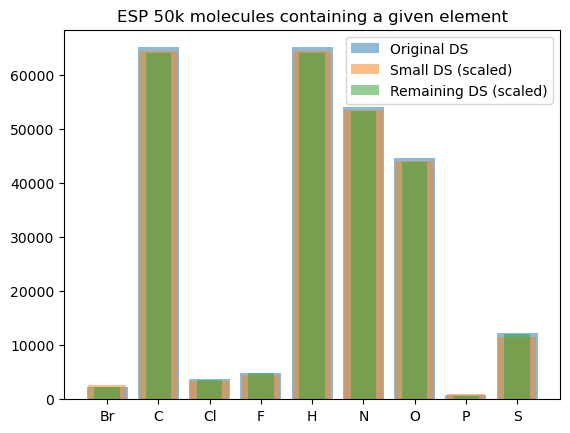

In [154]:
atoms_esp_labels,atoms_esp_counts = np.unique(atoms,return_counts=True)
atoms_random_x_esp_labels,atoms_random_x_esp_counts = np.unique(np.tile(atoms_random_x_esp,int(1/ft_esp)),return_counts=True)
atoms_random_y_esp_labels,atoms_random_y_esp_counts = np.unique(np.tile(atoms_random_y_esp,int(1/(1-ft_esp))),return_counts=True)

plt.figure()
plt.bar(atoms_esp_labels,atoms_esp_counts,alpha = 0.5,label='Original DS')
plt.bar(atoms_random_y_esp_labels,atoms_random_y_esp_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(atoms_random_x_esp_labels,atoms_random_x_esp_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("ESP 50k molecules containing a given element")
plt.show()

In [127]:
all_atoms_random_x_esp = [atom.symbol for mol in x_esp.X for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]

all_atoms_random_y_esp = []
for mol in y_esp.X:
    all_atoms_random_y_esp.extend([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])

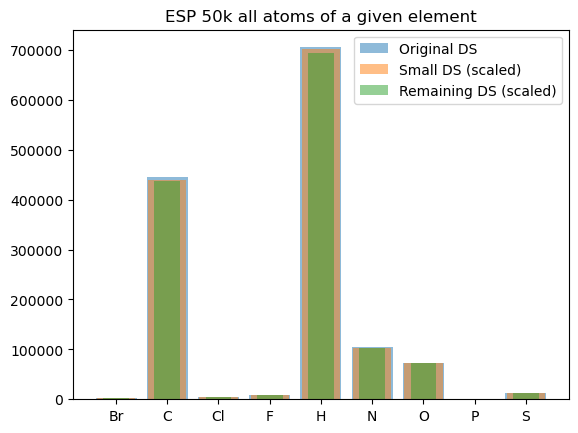

In [152]:
all_atoms_esp_labels,all_atoms_esp_counts = np.unique(esp_all_atoms,return_counts=True)
all_atoms_random_x_esp_labels,all_atoms_random_x_esp_counts = np.unique(np.tile(all_atoms_random_x_esp,int(1/ft_esp)),return_counts=True)
all_atoms_random_y_esp_labels,all_atoms_random_y_esp_counts = np.unique(np.tile(all_atoms_random_y_esp,int(1/(1-ft_esp))),return_counts=True)

plt.figure()
plt.bar(all_atoms_esp_labels,all_atoms_esp_counts,alpha = 0.5,label='Original DS')
plt.bar(all_atoms_random_y_esp_labels,all_atoms_random_y_esp_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(all_atoms_random_x_esp_labels,all_atoms_random_x_esp_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("ESP 50k all atoms of a given element")
plt.show()

### Multi-Br dataset
This will be harder to scale well since it's much smaller. Don't want to combine them, since the properties are so different.

In [129]:
ft_br=.984
x_br,y_br = random_splitter.train_test_split(dataset = dataset_br, frac_train = ft_br,seed=seed)#, frac_test = 0.5)
print(x_br.X.shape[0],y_br.X.shape[0])

633 11


In [130]:
# from openff.toolkit import Molecule
masses_random_x_br = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in x_br.X
])
print("MW (min, mean, max):", masses_random_x_br.min(), masses_random_x_br.mean(), masses_random_x_br.max())

MW (min, mean, max): 201.84508399999999 294.33477840039495 466.5868909999999


In [131]:
# from openff.toolkit import Molecule
masses_random_y_br = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in y_br.X
])
print("MW (min, mean, max):", masses_random_y_br.min(), masses_random_y_br.mean(), masses_random_y_br.max())

MW (min, mean, max): 237.88065400000002 281.0230742045455 329.81548799999996


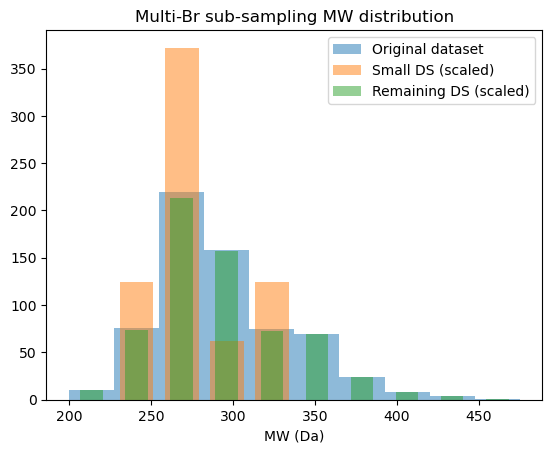

In [132]:
plt.figure()
plt.hist(masses_multibr,alpha = 0.5,range=(200,475),label='Original dataset')
plt.hist(np.tile(masses_random_y_br,int(1/(1-ft_br))),alpha = 0.5,range=(200,475),rwidth=0.75,label='Small DS (scaled)')
plt.hist(np.tile(masses_random_x_br,int(1/ft_br)),alpha = 0.5,range=(200,475),rwidth=0.5,label='Remaining DS (scaled)')
plt.title('Multi-Br sub-sampling MW distribution')
plt.xlabel("MW (Da)")
plt.legend()
plt.show()

In [133]:
atoms_random_x_br = []
for mol in x_br.X:
    atoms_random_x_br.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

atoms_random_y_br = []
for mol in y_br.X:
    atoms_random_y_br.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

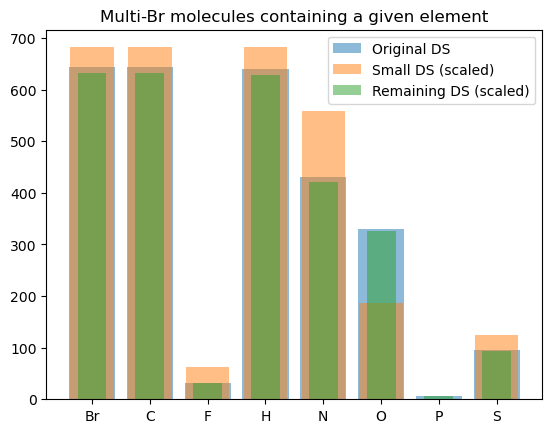

In [140]:
atoms_br_labels,atoms_br_counts = np.unique(atoms_br,return_counts=True)
atoms_random_x_br_labels,atoms_random_x_br_counts = np.unique(np.tile(atoms_random_x_br,int(1/ft_br)),return_counts=True)
atoms_random_y_br_labels,atoms_random_y_br_counts = np.unique(np.tile(atoms_random_y_br,int(1/(1-ft_br))),return_counts=True)

plt.figure()
plt.bar(atoms_br_labels,atoms_br_counts,alpha = 0.5,label='Original DS')
plt.bar(atoms_random_y_br_labels,atoms_random_y_br_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(atoms_random_x_br_labels,atoms_random_x_br_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("Multi-Br molecules containing a given element")
plt.show()

In [135]:
all_atoms_random_x_br = [atom.symbol for mol in x_br.X for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]

all_atoms_random_y_br = []
for mol in y_br.X:
    all_atoms_random_y_br.extend([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])

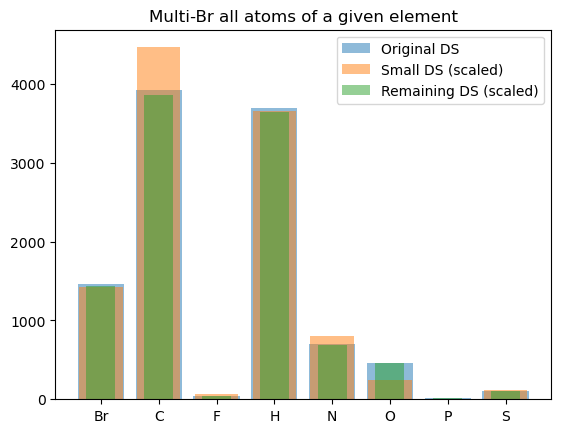

In [150]:
all_atoms_br_labels,all_atoms_br_counts = np.unique(br_all_atoms,return_counts=True)
all_atoms_random_x_br_labels,all_atoms_random_x_br_counts = np.unique(np.tile(all_atoms_random_x_br,int(1/ft_br)),return_counts=True)
all_atoms_random_y_br_labels,all_atoms_random_y_br_counts = np.unique(np.tile(all_atoms_random_y_br,int(1/(1-ft_br))),return_counts=True)

plt.figure()
plt.bar(all_atoms_br_labels,all_atoms_br_counts,alpha = 0.5,label='Original DS')
plt.bar(all_atoms_random_y_br_labels,all_atoms_random_y_br_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(all_atoms_random_x_br_labels,all_atoms_random_x_br_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("Multi-Br all atoms of a given element")
plt.show()

# Save new dataset

In [157]:
esp_subsample_records = BasicResultCollection.parse_obj({'entries':{"https://api.qcarchive.molssi.org:443/":[record for record in esp_50k_ds.entries["https://api.qcarchive.molssi.org:443/"] if record.record_id in y_esp.y]}})

In [164]:
br_subsample_records = OptimizationResultCollection.parse_obj({'entries':{"https://api.qcarchive.molssi.org:443/":[record for record in filtered_br_ds.entries["https://api.qcarchive.molssi.org:443/"] if record.record_id in y_br.y]}})

In [158]:
esp_subsample_records_filter = esp_subsample_records.filter(
    ConnectivityFilter(),
    ConformerRMSDFilter(rmsd_tolerance=0.05)
)

In [160]:
print(esp_subsample_records.n_results,esp_subsample_records_filter.n_results)

990 990


Great, filter didn't affect anything too much.

In [165]:
print(br_subsample_records.n_results)

11


In [166]:
with open('esp_subsample_filtered.json','w') as writefile:
    writefile.write(esp_subsample_records_filter.json(indent=2))

In [167]:
with open('br_subsample_filtered.json','w') as writefile:
    writefile.write(br_subsample_records.json(indent=2))